## Contour deformation 

In the context of GW method, contour deformation (CD) technique is used in conjunction with resolution of identity (RI) to reduce the formal scaling of the self-energy calculation. Compared to widely used analytic continuation approach it provides a means to evaluate self-energy  directly on the real axis without employing Pade approximants or non-linear least squares fit and potentially offering superior accuracy. Here, we provide a brief outline of the theory behind CD and give an example of the self-energy calculation within CD without invoking RI in order to facilitate comparison with the results prsented above. 

Detailed discussion of the CD can be found in the following papers:

1. Golze, D., Wilhelm, J., van Setten, M. J., & Rinke, P. (2018). Core-Level Binding Energies from GW : An Efficient Full-Frequency Approach within a Localized Basis. Journal of Chemical Theory and Computation, 14(9), 4856–4869. https://doi.org/10.1021/acs.jctc.8b00458

2. Giantomassi, M., Stankovski, M., Shaltaf, R., Grüning, M., Bruneval, F., Rinke, P., & Rignanese, G.-M. (2011). Electronic properties of interfaces and defects from many-body perturbation theory: Recent developments and applications. Physica Status Solidi (B), 248(2), 275–289. https://doi.org/10.1002/pssb.201046094

CD is used to recast the convolution in the GW expression of self-energy as a difference between two integrals, one which can be performed analytically whereas the other can be evaluated numerically on a relatively small grid. This is achieved by closing the inegration contour as shown below [2]:

![Integration contour used to evaluate $\Sigma(\omega)$](CD_scheme.jpg)

$$
\Sigma(r_1,r_2, \omega) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} e^{i\omega^{\prime} \eta} G(r_1, r_2, \omega + \omega^{\prime}) W(r_1, r_2, \omega^{\prime}) d\omega^{\prime}\\ 
= \frac{i}{2\pi} \oint_{\Gamma} G(r_1, r_2, \omega + z) W(r_1, r_2, z) dz -  \frac{1}{2\pi} \int_{-\infty}^{+\infty} G(r_1, r_2, \omega + i\omega^{\prime}) W(r_1, r_2, i\omega^{\prime}) d\omega^{\prime}
$$

Depending on the $\omega$ value the lower-left and the upper-right loops of the contour can enclose one or several poles of the zero-order Green's function whereas the poles of the screened Coulomb interaction never fall within the contour. This allowes to evaluate the countour integral as a sum of corresponding residues with apropriate signs (note that the upper-right loop is traversed counter-clockwise, while the lower-left loop is traversed clockwise). The imaginary axis contribution is calculated using Gauss-Legendre grid. Importantly, the intgrals over the arches vanish iff the screened Coulomb interaction does not contain the exchange contribution.

In [4]:
import psi4
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
#psi4.set_options({'basis' : 'cc-pvdz', 'd_convergence' : 1e-7,'scf_type' : 'out_of_core' })
h2o = psi4.geometry("""O   0.000000000000  -0.143225816552   0.000000000000 
                       H   1.638036840407   1.136548822547  -0.000000000000
                       H  -1.638036840407   1.136548822547  -0.000000000000
                       symmetry c1
                       units bohr
""")

#psi4.set_options({'basis': 'aug-cc-pvdz'})
psi4.set_options({'basis': 'cc-pvdz'})

#psi4.set_memory('2 GB')
psi4.set_output_file('h2o_accpvdz.out')

# Get the SCF wavefunction & energies
scf_e, scf_wfn = psi4.energy('hf', return_wfn=True)
#scf_e = psi4.energy('hf')

print("SCF energy is %16.10f" % scf_e)


SCF energy is   -75.9897775797


In [6]:
# GW implementation will be folded into a standalone class that uses molecule and wave function data from Psi4

class GW:
    
    def __init__(self, wfn, mol, gw_par):
        
        # wfn - Psi4 w.f. object from SCF calculation
        # mol - Psi4 molecule object
        # gw_par - is a dictionary with GW calculation parameters
        #          such as the number of states or the number of 
        #          omega sampling points
        
        self.scf_wfn = wfn
        self.mol = mol
        self.gw_par = gw_par
        
        
        self._init_sys_params() # sets some basic system parameters
        
        # Determine if we are doing RI
        
        self.do_ri = True if not 'do_ri' in gw_par.keys() else gw_par['do_ri']
        
        if self.do_ri:
            self._gen_ri_ints()     # generates integrals for RI-GW and
            # RI integrals are now available in self.nmR
        else:
            self._transform_eri()
            
        # Generate modified Gauss-Legendre grid for the frequency integration on imaginary axis
        
        self.gl_npoint =  40 if not 'gl_npoint' in gw_par.keys() else gw_par['gl_npoint']
        self._gen_gaussleg()
            
        # set GW calculation parameters
        
        # parameters of the self-energy calculation
        nomega_sigma =  501 if not 'nomega_sigma' in gw_par.keys() else gw_par['nomega_sigma']
        step_sigma = 0.01 if not 'step_sigma' in gw_par.keys() else  gw_par['step_sigma']
        
        # Quasi-particle states 
        self.no_qp = self.nocc if not 'no_qp' in gw_par.keys() else gw_par['no_qp'] # Number of hole states 
        self.nv_qp = 0 if not 'nv_qp' in gw_par.keys() else gw_par['nv_qp']             # Number of particle states
        self.eta = 1e-3  # Default eta value as recommended by F. Bruneval
        self.do_cd = True if not 'do_cd' in gw_par.keys() else gw_par['do_cd']
        
        # Quick sanity check
        
        assert self.no_qp <= self.nocc and self.nv_qp <= self.nvir

        # create an array of sampling frequencies similar to MolGW

        nomega_grid = nomega_sigma // 2 # note this is a truncation (aka integer) division
        omega_grid = np.array(range(-nomega_grid, nomega_grid + 1)) * step_sigma
        
        
        # sampling energies for all the states so we could calculate the self-energy matrix (broadcasting)

        omega_grid_all = omega_grid + self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp].reshape((-1, 1))
        assert omega_grid_all.shape == (self.no_qp + self.nv_qp, 2*nomega_grid + 1)
        print("Shape of the omega_grid_all is ", omega_grid_all.shape)
        self.omega_grid_all = np.copy(omega_grid_all)
        
        if self.do_cd:
            print("Using CD to calculate self-energy")
            Sigma_c_grid = self._calculate_CDGW(omega_grid_all) # self-energy matrix
            self.Sigma_c_grid = np.copy(Sigma_c_grid)
        else:
            print("Performing analytic calculation")
            self._calculate_W(gw_par)
            Sigma_c_grid = self._calculate_iGW(omega_grid_all) # self-energy matrix
            self.Sigma_c_grid = np.copy(Sigma_c_grid)
            
        # Apply solvers; Similar to MolGW - linear & graphic solutions

        print("Performing one-shot G0W0")
        
        qp_molgw_lin_ = np.zeros(self.no_qp + self.nv_qp)

        # Calculate pole strengths by performing numerical derivative on the omega grid

        zz = np.real(Sigma_c_grid[:, nomega_grid + 1] - Sigma_c_grid[:, nomega_grid - 1]) / (omega_grid[nomega_grid + 1] - omega_grid[nomega_grid - 1])
        zz = 1. / (1. - zz)
        zz[zz <= 0.0] = 0.0
        zz[zz >= 1.0] = 1.0
        
        qp_molgw_lin_ = self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp] + zz * np.real(Sigma_c_grid[:, nomega_grid])
        
        print("Perfoming graphic solution of the inverse Dyson equation")

        # both rhs and lhs of the QP equation have been calculated above
        
        qp_molgw_graph_ = np.copy(self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp])
        zz_graph = np.zeros(self.no_qp + self.nv_qp)
        
        for state in range(self.no_qp + self.nv_qp):
            z , e = self._find_fixed_point(omega_grid_all[state], np.real(Sigma_c_grid[state, :]) + self.eps[state + self.nocc - self.no_qp])
            if z[0] < 1e-6:
                print("Graphical solver failed for state %d" % (state + 1))
            # Do nothing since the array cell already contains HF orbital energy
            else:
                qp_molgw_graph_[state] = e[0]
                zz_graph[state] = z[0]
                
        self.zz = np.copy(zz)
        self.qp_molgw_lin_ = np.copy(qp_molgw_lin_)
        self.qp_molgw_graph_ = np.copy(qp_molgw_graph_)
                
        print("Done!")
        
    def print_summary(self):
        
        Ha2eV = 27.21138505
        
        print("E^lin, eV  E^graph, eV  Z ")
        for i in range(self.no_qp + self.nv_qp):
            print("%13.6f  %13.6f  %13.6f" % (self.qp_molgw_lin_[i]*Ha2eV, self.qp_molgw_graph_[i]*Ha2eV, self.zz[i]))
    
                
    def _init_sys_params(self):
        
        self.nocc = self.scf_wfn.nalpha()
        self.nbf = self.scf_wfn.nmo()
        self.nvir = self.nbf - self.nocc
        self.C = self.scf_wfn.Ca()
        
        self.Cocc = self.scf_wfn.Ca_subset("AO", "OCC")
        self.Cvirt = self.scf_wfn.Ca_subset("AO", "VIR")
        
        self.eps = np.asarray(self.scf_wfn.epsilon_a())
        
        # print a quick summary
        print("Number of basis functions: ", self.nbf)
        print("occ/virt: %d/%d" % (self.nocc, self.nvir))
    
    def _transform_eri(self):
        
        Co = self.Cocc
        C = self.C
        
        mints = psi4.core.MintsHelper(self.scf_wfn.basisset())
        self.MO = np.asarray(mints.mo_eri(Co, C, C, C))
        
    def _gen_ri_ints(self):
        
        # MO coefficients
        C = np.asarray(self.C)
        
        # Extract basis set from the wfn object
        orb = self.scf_wfn.basisset()
        
        # Build auxiliary basis set
        #aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "JKFIT", orb.name())
        aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "RIFIT", orb.name())
        #aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "RIFIT", "aug-cc-pVTZ")
        #aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "JKFIT", "aug-cc-pVTZ")
        
        
        # From Psi4 doc as of March, 2019 (http://www.psicode.org/psi4manual/1.2/psi4api.html#psi4.core.BasisSet.zero_ao_basis_set): 
        # Returns a BasisSet object that actually has a single s-function at 
        # the origin with an exponent of 0.0 and contraction of 1.0.
        zero_bas = psi4.core.BasisSet.zero_ao_basis_set()
        
        # Create a MintsHelper Instance
        mints = psi4.core.MintsHelper(orb)

        # Build (pq|P) raw 3-index ERIs, dimension (nbf, nbf, Naux, 1)
        pqP = mints.ao_eri(orb, orb, aux, zero_bas)

        # Build and invert the metric
        metric = mints.ao_eri(zero_bas, aux, zero_bas, aux)
        metric.power(-0.5, 1.e-14)
        
        # Remove the dimensions of size 1
        pqP = np.squeeze(pqP)
        metric = np.squeeze(metric)

        # Transform (pq|P) to obtain (nm|P) in molecular orbital basis
        nmP = np.einsum("pn, qm, pqR-> nmR", C, C, pqP)
        
        # Contract with the inverse square root of the metric tensor
        self.nmR = np.einsum( "nmP, PR-> nmR", nmP, metric)
        
        print("Auxiliary basis set has been generated!")
        print("Number of auxiliary basis functions: ", self.nmR.shape[2])
        
    def _gen_gaussleg(self):
        
        x, w = np.polynomial.legendre.leggauss(self.gl_npoint)
        # Modify points and weights as described here: 
        # Ren, X. et al. (2012). New Journal of Physics, 14(5), 053020
        self.gl_x = 0.5**((1 + x) / (1 - x))
        self.gl_w = w / (1-w)**2
        
        
    def _find_fixed_point(self, lhs, rhs):
        # This function returns an array of fixed points and correspoinding pole strengths
        # Its application can be vectorized using strandard NumPy np.vectorize
    
        assert lhs.shape == rhs.shape
    
        # Maximum number of fixed points (same as in MolGW)
        nfp_max = 4
    
        # Pole strength threshold
        pthresh = 1e-5
    
        # Arrays of f.p. energies and  Z
        zfp = np.zeros(nfp_max)
        zfp[:] = -1.0
        efp = np.zeros(nfp_max)
    
        # Auxiliary index array
        idx = np.arange(nfp_max)
    
        n = len(lhs)
        ifixed = 0
        g = rhs - lhs
    
        # loop over grid points excluding the last one
    
        for i in range(n - 1):
            if g[i] * g[i + 1] < 0.0:
                #print("Fixed point found betwenn %13.6f and %13.6f eV! " % (lhs[i] * Ha2eV, lhs[i+1] * Ha2eV))
                z_zero = 1. / ( 1. - ( g[i+1] - g[i] ) / ( lhs[i+1] - lhs[i] ) )
                if z_zero < pthresh:
                    continue
                # Do some bookkeeping; the code looks ugly but that is exactly what F.Bruneval has in MolGW package
            
                if z_zero > zfp[-1]:
                    jfixed = np.min(idx[z_zero > zfp])
                    zfp[jfixed + 1:] = zfp[jfixed:nfp_max - 1]
                    efp[jfixed + 1:] = efp[jfixed:nfp_max - 1]
                    zfp[jfixed] = z_zero
                    # Perfom linear interpolation to find the root
                    zeta = (g[i + 1] - g[i]) / (lhs[i + 1] - lhs[i])
                    efp[jfixed] = lhs[i] - g[i] / zeta
    
        #print("Graphical solver concluded operation")
        return (zfp, efp)
    
    def _calculate_W(self, gw_par):
        
                
        nocc = self.nocc
        nvir = self.nvir
        
        # Diagonal \epsilon_a - \epsilon_i
        eps_diag = self.eps[nocc:].reshape(-1, 1) - self.eps[:nocc]
        assert eps_diag.shape == (nvir, nocc)
        
        # A^{+} + B^{+}
        ApB = np.zeros((nocc, nvir, nocc, nvir))
        if self.do_ri:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * np.einsum("iaQ, jbQ->iajb", self.nmR[:nocc, nocc:], self.nmR[:nocc, nocc:])
        else:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * self.MO[:nocc, nocc:, :nocc, nocc: ]
        
                  
        
        ApB = ApB.reshape((nocc*nvir, nocc*nvir)) 
        # since nD numpy arrays have C-style memroy layout the occupied orbital inedex changes slower than the virtual one

        # Diagonal of  A^{+} - B^{+}
        AmB_diag = eps_diag.T.reshape((1, -1))
        AmB_diag = np.diag(AmB_diag[0,:])

        assert AmB_diag.shape == ApB.shape

        # Form C matrix (as one usually does when solving RPA eigenvalue problem)
        C_ = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), ApB, np.sqrt(AmB_diag))
        
        # Solve for the excitation energies and calculate X + Y eigenvectors
        
        omega2, Z = np.linalg.eigh(C_)
        self.omega_s = np.sqrt(omega2)
        self.xpy = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), Z, np.diag(1./np.sqrt(self.omega_s)))
        
    def _calculate_iGW(self, omega_grid_all):
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        # Self-energy denominators; those are of two kinds

        Dis = -eps[:nocc].reshape((-1, 1)) + self.omega_s
        Das = -eps[nocc:].reshape((-1, 1)) - self.omega_s 
        
        # Omega tensors; This will be refactored to improve memory efficiency
        i_rtia = np.zeros((nbf,nbf, nocc, nvir))
        if self.do_ri:
            i_rtia = np.einsum("iaQ, rtQ ->rtia", self.nmR[:nocc, nocc:, :], self.nmR) 
            i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))
        else:
            i_rtia = np.einsum("iart->rtia", self.MO[:nocc,nocc:,:,:]) 
            i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))
            
        omega_rts = np.sqrt(2.) * np.einsum("rtk, ks->rts", i_rtia, self.xpy)
        
        #Calculate denominators
        
        Dis_ = Dis + omega_grid_all.reshape((no_qp + nv_qp, omega_grid_all.shape[1], 1, 1)) - 1.j*self.eta
        Das_ = Das + omega_grid_all.reshape((no_qp + nv_qp, omega_grid_all.shape[1], 1, 1)) + 1.j*self.eta

        # self-energy matrix (with the shape (no_qp + nv_qp, 2*nomega_grid + 1))

        # Contribution due to occupied orbitals (note that the shape of the structure of the denominator array is not optimal)
        Sigma_c_grid = np.einsum("kis, klis, kis->kl", omega_rts[nocc - no_qp:nocc + nv_qp,:nocc,:], 1./Dis_, omega_rts[nocc - no_qp:nocc + nv_qp,:nocc,:])
        # Contribution due to virtuals
        Sigma_c_grid +=  np.einsum("kas, klas, kas->kl", omega_rts[nocc - no_qp:nocc + nv_qp,nocc:,:], 1./Das_, omega_rts[nocc - no_qp:nocc + nv_qp,nocc:,:])
 
        
        return Sigma_c_grid
    
    def _calculate_CDGW(self, omega_grid_all):
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        eta = self.eta
        
        naux = self.nmR.shape[2]
        e_fermi = (eps[nocc - 1] + eps[nocc]) / 2.
                
        # Orbital energy difference
        e_ai = eps[nocc:, np.newaxis] - eps[np.newaxis, :nocc]
        
        im_omega = self.gl_x * 1.j
        dp =  e_ai[np.newaxis, :, :] + im_omega[:, np.newaxis, np.newaxis]
        dm = -e_ai[np.newaxis, :,:] + im_omega[:, np.newaxis, np.newaxis]
        assert dp.shape == (len(self.gl_x), nvir, nocc) and dm.shape == (len(self.gl_x), nvir, nocc)
        # The grid index comes first because of the way np.lingalg.inv function works (as well as C-style matrix layout)
        
        Ppq = np.einsum("iaP, lai, iaQ -> lPQ", self.nmR[:nocc, nocc:, :], 1./ (dm + 1.j * eta) - 1./ (dp - 1.j * eta), self.nmR[:nocc, nocc:, :])
                       
        # Calculate screened Coulomb interaction W
        id_pq = np.eye(naux)
        O = self.nmR[nocc - no_qp:nocc + nv_qp, :, :]
        Wnm = np.einsum("nmP, lPQ, nmQ -> nml", O, (np.linalg.inv(id_pq[np.newaxis, :,:] - Ppq) - id_pq[np.newaxis, :,:]), O)
        
        # Calculate some intermediates for the imaginary time integration
        f = np.ones(nbf)
        f[eps > e_fermi] = -1.
        complex_eps = eps + 1.j * eta * f
        
        ngrid = omega_grid_all.shape[1]
        In = np.zeros(omega_grid_all.shape, dtype=np.complex128)
        Rn = np.zeros(omega_grid_all.shape, dtype=np.complex128)
        
        # Perform the imaginary frequency integral for each batch of the points on the real axis
        # This will be slow in Python but I don't want to mess around with broadcasting here too much...
        for gp in range(ngrid):
            batch = omega_grid_all[:, gp]
            #print("shape of batch ", batch.shape)
            batch = batch.reshape((-1, 1, 1)) 
            denom_p = 1. /  (batch + complex_eps[np.newaxis, :, np.newaxis] + im_omega[np.newaxis, np.newaxis, :])
            denom_m = 1. /  (batch + complex_eps[np.newaxis, :, np.newaxis] - im_omega[np.newaxis, np.newaxis, :])
            In[:, gp] = 1. / (2.*np.pi) * np.einsum("nml, l->n", Wnm * (denom_p + denom_m) , self.gl_w)
                
            # Calculate the residue term if needed  
                               
            # batch = np.squeeze(batch) # turns batch into scalar if one state is requested
            batch = batch.reshape((1,-1))
            #print("Shape of batch after squezzing : ", batch.shape)
            assert len(batch) == no_qp + nv_qp
            eps_batch = eps[:, np.newaxis] - batch
            
            for bp in range(len(batch)):
                # bp corresponds to a qp state with index bp!
                # select orbital indexes that contribute
                ospace = np.arange(nbf)
                mask_occ = np.logical_and((eps_batch[:, bp] > 0.0), (ospace < nocc)) 
                mask_vir = np.logical_and((eps_batch[:, bp] < 0.0), (ospace >= nocc)) 
                mask = np.logical_or(mask_occ, mask_vir)
                ospace_res = ospace[mask]
                
                # ospace[mask] - orbital indeces that contribute for a given batch point bp
                # we need to correctly define sign factors now
                ones = np.ones(nbf).reshape((-1, 1))
                sign = np.vstack((-1. * ones[mask_occ], ones[mask_vir]))
                
                
                if len(ospace_res) == 0:
                    # No poles inside the integration contour
                    # That should hold true only if the frequency is inside the gap
                    #print("Residue term will not be calculated at this time")
                    assert (batch[bp] >= eps[nocc - 1]) and (batch[bp] <= eps[nocc])
                    continue
                else:
                    # K = [1 - P]^(-1); tensor K has shape (len(ospace_res), naux, naux)
                    complex_eps_ = np.abs(eps_batch[ospace_res, bp]) + 1.j * eta # different from complex_eps defined above!
                    dp_ =  e_ai[np.newaxis, :,:] + complex_eps_[:, np.newaxis, np.newaxis]
                    dm_ = -e_ai[np.newaxis, :,:] + complex_eps_[:, np.newaxis, np.newaxis]
                    assert dp_.shape == (len(ospace_res), nvir, nocc) and dm_.shape == (len(ospace_res), nvir, nocc)
                    Ppq_ = np.einsum("iaP, lai, iaQ -> lPQ", self.nmR[:nocc,nocc:,:], 1./ (dm_ + 1.j * eta) - 1./ (dp_ - 1.j * eta), self.nmR[:nocc, nocc:, :])
                    assert Ppq_.shape == (len(ospace_res), naux, naux)
                    # Note that Ppq_ has different shape compared to Ppq
                    dpq_ = np.eye(naux) 
                    # Will print shapes of the operands here
                    
                    O_ = self.nmR[nocc- no_qp + bp, ospace_res, :]
                    
                    #print("O_ ", O_.shape)
                    #print("dpq_ ", dpq_.shape)
                    #print("Ppq_ ", Ppq_.shape)
                    #print("sign ", sign.shape)
                    
                    Rn[bp, gp] = np.einsum("mP, mPQ, mQ, m->", O_, (np.linalg.inv(dpq_[np.newaxis, :, :] - Ppq_) - dpq_[np.newaxis,:,:]), O_, sign[:, 0])
        
        
        Sigma_c = Rn - In
        
        return Sigma_c
    
    def W_aux(self, n, m, omega_grid):
        # This function performs calculation of the screened Coulomb interaction
        # on a frequency grid using RI approach and is identical to the one used 
        # in AC and CD codes
        
        omega_grid = np.asarray(omega_grid)
        assert len(omega_grid.shape) == 1 # omega_grid is assumed to be a one-dimensional array
                
        # References to the basic system parameters
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        eta = self.eta
        
        # The following code forces RI integral calculation even if it is not requested 
        # in gw_par
        
        needRI = False
        if hasattr(self, 'do_ri'):
            if not self.do_ri:
                needRI = True
        else:
            needRI = True
            
        # If need to generate RI -> do it!
        if needRI:
            self._gen_ri_ints()
            
        naux = self.nmR.shape[2]
        
        thresh = 1e-14
        # Orbital energy difference
        e_ai = eps[nocc:, np.newaxis] - eps[np.newaxis, :nocc]
        assert e_ai.shape == (nvir, nocc)
        
        # Calculate Pi_{PQ} on a grid; Grid index should be along the firest dimension of the corresponding 
        # tensor due to the way NumPy works
        O_ = self.nmR[:nocc, nocc:, :]
        dp_ = omega_grid[:,np.newaxis, np.newaxis] + e_ai[np.newaxis, :, :] - 1.j * eta
        dm_ = omega_grid[:,np.newaxis, np.newaxis] - e_ai[np.newaxis, :, :] + 1.j * eta
        assert dp_.shape == (len(omega_grid), nvir, nocc) and dm_.shape == (len(omega_grid), nvir, nocc)
        for i in range(len(omega_grid)):
            for a in range(nvir):
                for j in range(nocc):
                    d = dp_[i, a, j] - (omega_grid[i] + eps[a + nocc] - eps[j] - 1.j * eta)
                    assert np.abs(d.real) <= thresh and np.abs(d.imag) <= thresh
                    d = dm_[i, a, j] - (omega_grid[i] - eps[a + nocc] + eps[j] + 1.j * eta)
                    assert np.abs(d.real) <= thresh and np.abs(d.imag) <= thresh
        
        eyepq = np.eye(naux)
        assert eyepq.shape == (naux, naux) and np.all(np.diag(eyepq) == np.ones(naux))
        Ppq_ = np.einsum("iaP, gai, iaQ->gPQ", O_, 1./dm_ - 1./dp_, O_)
        assert Ppq_.shape == (len(omega_grid), naux, naux)
        
        # Will compare the matrices at the first grid point since
        # calculating the full tensor is expensive if plain Python
        # loops are used
        Ppq__ = np.zeros((naux, naux), dtype=np.complex128)
        for P in range(naux):
            for Q in range(naux):
                for a in range(nvir):
                    for j in range(nocc):
                        
                        Ppq__[P, Q] += O_[j, a, P] * O_[j, a, Q] * (1./(omega_grid[0] - eps[a + nocc] + eps[j] + 1.j * eta) - 1./(omega_grid[0] + eps[a + nocc] - eps[j] - 1.j * eta))
                        
        dP_matr = np.abs(Ppq__ - Ppq_[0, :, :])
        #print("Max error is ", np.max(dP_matr.real), np.max(dP_matr.imag))
        assert np.allclose(Ppq__, Ppq_[0, :, :])
        
        #Ppq__ = np.zeros(Ppq_.shape, dtype=np.complex128)
        #for i in range(len(omega_grid)):
        #    for P in range(naux):
        #        for Q in range(naux):
        #            for a in range(nvir):
        #                for j in range(nocc):
        #                    Ppq__[i, P, Q] += O_[j, a, P] * O_[j, a, Q] * (1./(omega_grid[i] - eps[a + nocc] + eps[j] + 1.j * eta) - 1./(omega_grid[i] + eps[a + nocc] - eps[j] - 1.j * eta))
  
        #assert np.allclose(Ppq__, Ppq_)
        
        Wnm = np.einsum("P, gPQ, Q->g", self.nmR[n, m, :], np.linalg.inv(eyepq[np.newaxis, :, :] - Ppq_), self.nmR[m,n,:])
        print("Shape of Wnm is ", Wnm.shape)
        
        # Will now calculate Wnm without broadcasting and will compart the result with Wnm
        # It will be assumed that Ppq_ tensor is correct:
        
        Wnm__ = np.zeros(Wnm.shape, dtype=np.complex128)
        for i in range(len(omega_grid)):
            invPpq_ = np.linalg.inv(eyepq - Ppq_[i, :, :])
            for P in range(naux):
                for Q in range(naux):
                    Wnm__[i] += self.nmR[n, m, P] * self.nmR[m, n, Q] * invPpq_[P, Q]
                    
        assert np.allclose(Wnm__, Wnm)
        
        return Wnm
    
    def W_aux_full(self, omega_grid):
        # This function checks if the  W tensor calculated using RI 
        # satisfies Dyson equation
        
        omega_grid = np.asarray(omega_grid)
        assert len(omega_grid.shape) == 1 # omega_grid is assumed to be a one-dimensional array
                
        # References to the basic system parameters
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        eta = self.eta
        
        # The following code forces RI integral calculation even if it is not requested 
        # in gw_par
        
        needRI = False
        if hasattr(self, 'do_ri'):
            if not self.do_ri:
                needRI = True
        else:
            needRI = True
            
        # If need to generate RI -> do it!
        if needRI:
            self._gen_ri_ints()
            
        naux = self.nmR.shape[2]
        
        # Orbital energy difference
        e_ai = eps[nocc:, np.newaxis] - eps[np.newaxis, :nocc]
        assert e_ai.shape == (nvir, nocc)
        
        # Calculate Pi_{PQ} on a grid; Grid index should be along the firest dimension of the corresponding 
        # tensor due to the way NumPy works
        O_ = self.nmR[:nocc, nocc:, :]
        dp_ = omega_grid[:,np.newaxis, np.newaxis] + e_ai[np.newaxis, :, :] - 1.j * eta
        dm_ = omega_grid[:,np.newaxis, np.newaxis] - e_ai[np.newaxis, :, :] + 1.j * eta
        
        eyepq = np.eye(naux)
        assert eyepq.shape == (naux, naux) and np.all(np.diag(eyepq) == np.ones(naux))
        Ppq_ = np.einsum("iaP, gai, iaQ->gPQ", O_, 1./dm_ - 1./dp_, O_)
        assert Ppq_.shape == (len(omega_grid), naux, naux)
        
        Wnmkl = np.einsum("nmP, gPQ, klQ->gnmkl", self.nmR, np.linalg.inv(eyepq[np.newaxis, :, :] - Ppq_), self.nmR)
        MO = np.einsum("nmR, klR-> nmkl", self.nmR, self.nmR)
        
        diff = Wnmkl - np.einsum("nmia, gai, giakl->gnmkl", MO[:,:,:nocc,nocc:], 1./dm_ - 1./dp_, Wnmkl[:,:nocc,nocc:,:,:]) - MO[np.newaxis, :, :, :, :]
        
        thresh = 1e-14
        print(np.max(np.real(diff)))
        print(np.max(np.imag(diff)))
        assert np.all(np.abs(np.real(diff)) < thresh) and np.all(np.abs(np.imag(diff)) < thresh)
        
    
    def W_analytic(self, n, m, omega_grid):
        # This function implements a standalone W calculation using spectral representation
        # Similar to W_aux it is meant to be used for benchmarking purposes only
        
        omega_grid = np.asarray(omega_grid)
        assert len(omega_grid.shape) == 1 # omega_grid is assumed to be a one-dimensional array
                
        # References to the basic system parameters
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        eta = self.eta
        
        # The following code forces direct integral calculation even if it is not requested 
        # in gw_par
        
        if not hasattr(self, 'MO'):
            self._transform_eri()
            self._calculate_W(self.gw_par)
            
        # All the intermediates are now created; proceed to omega tensors and W denominators
        dp_ = omega_grid[:,np.newaxis] + self.omega_s[np.newaxis, :] - 1.j * eta
        dm_ = omega_grid[:,np.newaxis] - self.omega_s[np.newaxis, :] + 1.j * eta
        
        i_nmia = self.MO[n,m,:nocc,nocc:] 
        i_nmia = i_nmia.reshape((1, -1))
            
        omega_nms = np.sqrt(2.) * np.einsum("k, ks->s", i_nmia[0,:], self.xpy)
        
        Wnm = self.MO[n, m, m, n] + np.einsum("s, gs, s", omega_nms, 1./dm_ - 1./dp_, omega_nms)
        
        return Wnm
    
    def W_analytic_full(self, omega_grid):
        # Calculates a 5 index W tensor on a grid and check if it satifies the Dyson equation
        omega_grid = np.asarray(omega_grid)
        assert len(omega_grid.shape) == 1 # omega_grid is assumed to be a one-dimensional array
                
        # References to the basic system parameters
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        eta = self.eta
        
        e_ai = eps[nocc:, np.newaxis] - eps[np.newaxis, :nocc]
        assert e_ai.shape == (nvir, nocc)
        
        
        # The following code forces direct integral calculation even if it is not requested 
        # in gw_par
        
        if not hasattr(self, 'MO'):
            C = self.C
            mints = psi4.core.MintsHelper(self.scf_wfn.basisset())
            self.MO = np.asarray(mints.mo_eri(C, C, C, C))
            self._calculate_W(self.gw_par)
            
        # All the intermediates are now created; proceed to omega tensors and W denominators
        i_rtia = np.einsum("iart->rtia", self.MO[:nocc,nocc:,:,:]) 
        i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))
            
        omega_rts = np.sqrt(2.) * np.einsum("rtk, ks->rts", i_rtia, self.xpy)
                
        dp_ = omega_grid[:,np.newaxis] + self.omega_s[np.newaxis, :] - 1.j * eta
        dm_ = omega_grid[:,np.newaxis] - self.omega_s[np.newaxis, :] + 1.j * eta
        
        W_mat = self.MO[np.newaxis, :,:,:,:] + np.einsum("mns, gs, ops -> gmnop", omega_rts, 1./dm_ - 1./dp_, omega_rts)
        
        # Check if W_mat satisfies the "dyson equation"
        dporb_ = omega_grid[:,np.newaxis, np.newaxis] + e_ai[np.newaxis, :, :] - 1.j * eta
        dmorb_ = omega_grid[:,np.newaxis, np.newaxis] - e_ai[np.newaxis, :, :] + 1.j * eta
        
        diff = W_mat - np.einsum("nmia, gai, giakl->gnmkl", self.MO[:,:,:nocc,nocc:], 1./dmorb_ - 1./dporb_, W_mat[:,:nocc,nocc:,:,:]) - self.MO[np.newaxis, :, :, :, :]
        
        thresh = 1e-14
        print(np.max(np.real(diff)))
        print(np.max(np.imag(diff)))
        assert np.all(np.abs(np.real(diff)) < thresh) and np.all(np.abs(np.imag(diff)) < thresh)
        
        
                
   


In [7]:
# Test case
gw_par = {'no_qp' : 1, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True} # Can only run with do_ri = True for now

gw_h2o_accpvdz = GW(scf_wfn, h2o, gw_par)
gw_h2o_accpvdz.print_summary()

Number of basis functions:  24
occ/virt: 5/19
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  84
Shape of the omega_grid_all is  (1, 501)
Using CD to calculate self-energy
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
   -13.319419     -13.282570       0.135522


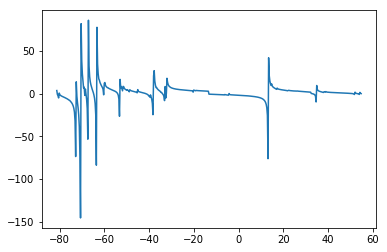

In [8]:
au2ev = 27.21138505
plt.plot(gw_h2o_accpvdz.omega_grid_all[0,:] * au2ev  , np.real(gw_h2o_accpvdz.Sigma_c_grid[0,:]) * au2ev)

In [9]:
grid = gw_h2o_accpvdz.omega_grid_all[0, :]
gw_h2o_accpvdz.W_analytic_full(grid)

0.24018969195467754
0.5956488707391241


AssertionError: 

In [41]:
grid = gw_h2o_accpvdz.omega_grid_all[0, :]
i = gw_h2o_accpvdz.nocc - 1
# Calculate Wii element of screened Coulomb interaction using RI and analytic approaches and compare the results
# for a series of energies in grid
W_approx = gw_h2o_accpvdz.W_aux(i, i, grid)
W_exact = gw_h2o_accpvdz.W_analytic(i, i, grid)
identical = np.allclose(W_approx, W_exact)
print("The two arrays are identical? ", identical)
max_abs_err = np.max(np.abs(W_approx - W_exact))
print(max_abs_err)

Shape of Wnm is  (501,)
The two arrays are identical?  False
42.83559873083306


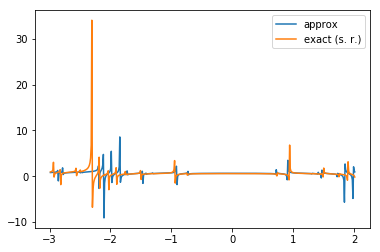

In [43]:
#window = np.logical_and(grid < -1., grid > -2.)
window = np.logical_and(grid < 100., grid > -100.)
plt.plot(grid[window], W_approx[window], label = 'approx')
plt.plot(grid[window], W_exact[window], label = 'exact (s. r.)')
plt.legend()

In [47]:
gw_par_analytic = {'no_qp' : 1, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True, 'do_cd' : False} 
gw_par_analytic_nori = {'no_qp' : 1, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : False, 'do_cd' : False}

print("+++ Analytic calculation with RI +++")
gw_h2o_accpvdz_a = GW(scf_wfn, h2o, gw_par_analytic)
gw_h2o_accpvdz_a.print_summary()

print("+++ Analytic calculation without RI +++")
gw_h2o_accpvdz_nori = GW(scf_wfn, h2o, gw_par_analytic_nori)
gw_h2o_accpvdz_nori.print_summary()


+++ Analytic calculation with RI +++
Number of basis functions:  41
occ/virt: 5/36
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  150
Shape of the omega_grid_all is  (1, 501)
Performing analytic calculation
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
   -12.059279     -12.055024       0.921946
+++ Analytic calculation without RI +++
Number of basis functions:  41
occ/virt: 5/36
Shape of the omega_grid_all is  (1, 501)
Performing analytic calculation
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
   -12.059938     -12.055687       0.921942


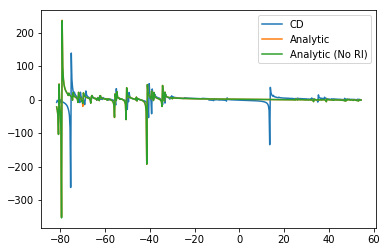

In [48]:
au2ev = 27.21138505
plt.plot(gw_h2o_accpvdz.omega_grid_all[0,:] * au2ev  , np.real(gw_h2o_accpvdz.Sigma_c_grid[0,:]) * au2ev, label='CD')
plt.plot(gw_h2o_accpvdz_a.omega_grid_all[0,:] * au2ev  , np.real(gw_h2o_accpvdz_a.Sigma_c_grid[0,:]) * au2ev, label='Analytic')
plt.plot(gw_h2o_accpvdz_nori.omega_grid_all[0,:] * au2ev  , np.real(gw_h2o_accpvdz_nori.Sigma_c_grid[0,:]) * au2ev, label='Analytic (No RI)')
plt.legend()

In [51]:
# Testing convergence with respect to the number of quadrature points
gw_par1 = {'no_qp' : 1, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True, 'gl_npoint' : 80}

gw_h2o_accpvdz1 = GW(scf_wfn, h2o, gw_par1)
gw_h2o_accpvdz1.print_summary()

Number of basis functions:  41
occ/virt: 5/36
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  150
Shape of the omega_grid_all is  (1, 501)
Using CD to calculate self-energy
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
   -13.773493     -13.700286       0.123167


In [52]:
print(gw_h2o_accpvdz1.gl_npoint)

80


In [53]:
gw_par2 = {'no_qp' : 1, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True, 'gl_npoint' : 160}

gw_h2o_accpvdz2 = GW(scf_wfn, h2o, gw_par2)
gw_h2o_accpvdz2.print_summary()

Number of basis functions:  41
occ/virt: 5/36
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  150
Shape of the omega_grid_all is  (1, 501)
Using CD to calculate self-energy
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
   -13.768911     -13.697782       0.123247


In [54]:
gw_par3 = {'no_qp' : 1, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True, 'gl_npoint' : 320}

gw_h2o_accpvdz3 = GW(scf_wfn, h2o, gw_par3)
gw_h2o_accpvdz3.print_summary()

Number of basis functions:  41
occ/virt: 5/36
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  150
Shape of the omega_grid_all is  (1, 501)
Using CD to calculate self-energy
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
   -13.766691     -13.696569       0.123286


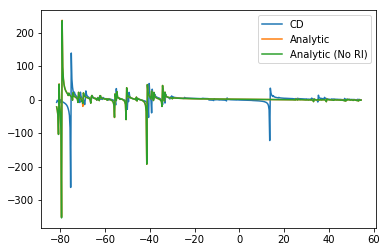

In [55]:
plt.plot(gw_h2o_accpvdz3.omega_grid_all[0,:] * au2ev  , np.real(gw_h2o_accpvdz3.Sigma_c_grid[0,:]) * au2ev, label='CD')
plt.plot(gw_h2o_accpvdz_a.omega_grid_all[0,:] * au2ev  , np.real(gw_h2o_accpvdz_a.Sigma_c_grid[0,:]) * au2ev, label='Analytic')
plt.plot(gw_h2o_accpvdz_nori.omega_grid_all[0,:] * au2ev  , np.real(gw_h2o_accpvdz_nori.Sigma_c_grid[0,:]) * au2ev, label='Analytic (No RI)')
plt.legend()